In [1]:
## Import necessary libraries

import mne
import numpy as np
import matplotlib.pyplot as plt
# import torch
from scipy.io import loadmat
from scipy.special import sph_harm
from numpy.linalg import solve
import json
from scipy.interpolate import RegularGridInterpolator

In [2]:
import numpy as np, matplotlib.pyplot as plt, os
from matplotlib import gridspec
from scipy import ndimage
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from sklearn.datasets import load_digits
try:
    from gtda.time_series import TakensEmbedding, SlidingWindow
    from gtda.homology import VietorisRipsPersistence
    from gtda.plotting import plot_diagram
    HAVE_GIOTTO = True
except Exception:
    HAVE_GIOTTO = False

In [3]:
good = [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 38, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 65]
good = np.array(good) - 1
subjects = ["01", "02", "04", "09", "15", "37", "79"]
auds = [f"{i:02d}" for i in range(1, 24)]

bad = set(range(65)) - set(good)

san_disk = 'D:/Universidad/2025_2/TDA/data'

In [9]:
import torch
from torchph.pershom import CubicalPersistence

cp = CubicalPersistence()

def cubical_pd_from_image_gpu(img):
    t = torch.tensor(img, dtype=torch.float32, device="cuda")[None, None, ...]
    # shape: (batch=1, channel=1, H, W)
    intervals = cp(t)
    return [intervals[0].cpu().numpy(), intervals[1].cpu().numpy()]

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchph\pershom\pershom_backend.py:82: UserWarning: 
    Failed jit compilation in c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchph\pershom\pershom_backend.py.
    Error was `Ninja is required to load C++ extensions`.
    The error will be re-raised calling any function in this module.
    
  warnings.warn(_failed_compilation_msg.format(__file__, ex))


ImportError: cannot import name 'CubicalPersistence' from 'torchph.pershom' (c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchph\pershom\__init__.py)

In [4]:
def cubical_pd_from_image(img):
    cc = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    cc.compute_persistence()
    D0 = np.array(cc.persistence_intervals_in_dimension(0))
    D1 = np.array(cc.persistence_intervals_in_dimension(1))
    return [D0.tolist(), D1.tolist()]

def gudhi_rips_diagrams(X, maxdim=1, max_edge_length=None):
    max_edge = np.inf if max_edge_length is None else max_edge_length
    rc = gd.RipsComplex(points=X, max_edge_length=max_edge)
    st = rc.create_simplex_tree(max_dimension=maxdim+1)
    st.compute_persistence() # [(dim, [birth, death])]
    dgms = []
    # como gudhi tiene los intervalos (dim, [birth, death]) lo homogenizamos con el formato de ripser
    # una lista de listas de intervalos
    for dim in range(maxdim+1):
        d = st.persistence_intervals_in_dimension(dim)
        # Gudhi usa 'inf' para muertes infinitas; lo dejamos así para compatibilidad con persim
        dgms.append(np.array(d, dtype=float))
    return dgms

In [5]:
def combine_diagrams(Ds):
    """
    Convert [D0, D1] → (n_points_total, 3) array with homology dimension labels.
    """
    D0, D1 = Ds
    D0 = np.asarray(D0, dtype=float)
    D1 = np.asarray(D1, dtype=float)

    # Add homology dimension label as 3rd column
    D0_labeled = np.hstack([D0, np.zeros((len(D0), 1))])
    D1_labeled = np.hstack([D1, np.ones((len(D1), 1))])

    # Concatenate into one array
    return np.vstack([D0_labeled, D1_labeled])

def pd_basic_features(D):
    births, deaths = D[:,0], D[:,1]
    lifetimes = deaths - births
    return {
        "num": len(D),
        "mean": np.mean(lifetimes),
        "max": np.max(lifetimes),
        "sum": np.sum(lifetimes),
        "std": np.std(lifetimes)
    }

def persistence_entropy(D):
    lifetimes = D[:,1] - D[:,0]
    if np.sum(lifetimes) == 0:
        return 0.0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p + 1e-10))

def betti_curve_from_diagram(diag: np.ndarray, t_grid: np.ndarray) -> np.ndarray:
    """Cuenta, para cada t en t_grid, cuántos intervalos (b,d) activan: b <= t < d.
    diag: array de pares (b,d) (puede contener d = inf)"""
    if len(diag) == 0:
        return np.zeros_like(t_grid, dtype=float)
    b = [case[0] for case in diag] # todos los births
    d = [case[1] for case in diag] # todos los deaths
    out = np.zeros_like(t_grid, dtype=float)
    for i, t in enumerate(t_grid):
        out[i] = np.sum((b <= t) & (t < d)) # número de intervalos de persistencia "vivos" en el tiempo t
    return out

def euler_curve_from_diagrams(diagrams: list[np.ndarray], t_grid: np.ndarray) -> np.ndarray:
    """E(t) = sum_k (-1)^k * beta_k(t)"""
    E = np.zeros_like(t_grid, dtype=float)
    for k, Dk in enumerate(diagrams):
        if len(Dk) == 0:
            continue
        E += ((-1)**k) * betti_curve_from_diagram(Dk, t_grid)
    return E


# ---------------------
# Paisajes de persistencia (versión simple)
# ---------------------
def _hat_height(t, b, d):
    # Triangular hat: max(0, min(t-b, d-t))
    if np.isinf(d):
        # Si la muerte es infinita, acotamos artificialmente (para visualización)
        d = b + 2.0
    return max(0.0, min(t - b, d - t))

def persistence_landscapes(diag: np.ndarray, t_grid: np.ndarray, k_max=3) -> np.ndarray:
    """Devuelve una matriz (k_max, len(t_grid)) con los k primeros paisajes."""
    L = np.zeros((k_max, len(t_grid)), dtype=float)
    if len(diag) == 0:
        return L
    for j, t in enumerate(t_grid):
        vals = [_hat_height(t, case[0], case[1]) for case in diag]
        vals.sort(reverse=True)
        m = min(k_max, len(vals))
        L[:m, j] = vals[:m]
    return L

def features_from_pd_list(D_list):
        feats = []
        t_grid = np.linspace(-1e-15, 2e-15, 50)
        for D in D_list:
            # min_t, max_t = D[:,0].min(), D[:,1].max()
            # t_grid = np.linspace(min_t, max_t, 50)
            b0 = betti_curve_from_diagram([case for case in D if case[2] < 0.5], t_grid) if len(D)>0 else np.zeros(t_grid)
            b1 = betti_curve_from_diagram([case for case in D if case[2] > 0.5], t_grid) if len(D)>1 else np.zeros(t_grid)
            E  = euler_curve_from_diagrams([[case for case in D if case[2] < 0.5], [case for case in D if case[2] > 0.5]], t_grid)
            L0  = persistence_landscapes([case for case in D if case[2] < 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            L1  = persistence_landscapes([case for case in D if case[2] > 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            lifetimes_0 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_0 = np.isfinite(lifetimes_0)
            filtered_arr_0 = lifetimes_0[finite_mask_0]

            mean_life_0 = filtered_arr_0.mean() if len(filtered_arr_0) > 0 else 0
            max_life_0 = filtered_arr_0.max() if len(filtered_arr_0) > 0 else 0
            var_life_0 = filtered_arr_0.var() if len(filtered_arr_0) > 0 else 0

            lifetimes_1 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_1 = np.isfinite(lifetimes_1)
            filtered_arr_1 = lifetimes_1[finite_mask_1]

            mean_life_1 = filtered_arr_1.mean() if len(filtered_arr_1) > 0 else 0
            max_life_1 = filtered_arr_1.max() if len(filtered_arr_1) > 0 else 0
            var_life_1 = filtered_arr_1.var() if len(filtered_arr_1) > 0 else 0

            num_infinite_0 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 0])
            num_infinite_1 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 1])

            if len(filtered_arr_0) > 0:
                probs_0 = filtered_arr_0 / filtered_arr_0.sum()
                entropy_0 = -np.sum(probs_0 * np.log(probs_0))
            else:
                entropy_0 = 0

            if len(filtered_arr_1) > 0:
                probs_1 = filtered_arr_1 / filtered_arr_1.sum()
                entropy_1 = -np.sum(probs_1 * np.log(probs_1))
            else:
                entropy_1 = 0

            feats.append([
                mean_life_0,
                max_life_0,
                var_life_0,
                num_infinite_0,
                entropy_0,
                np.trapz(b0, t_grid),          # área bajo Betti0
                b0.max(),                      # peak Betti0
                L0[0].max() if L0.size>0 else 0, # peak λ0
                np.trapz(np.abs(L0[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L0[0]**2, t_grid)),  # p=2

                mean_life_1,
                max_life_1,
                var_life_1,
                num_infinite_1,
                entropy_1,
                np.trapz(b1, t_grid),          # área bajo Betti1
                b1.max(),                      # peak Betti1
                L1[0].max() if L1.size>0 else 0, # peak λ1
                np.trapz(np.abs(L1[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L1[0]**2, t_grid)),  # p=2
                
                np.trapz(np.abs(E), t_grid),   # área Euler
            ])
        return np.array(feats)

In [6]:
from persim import wasserstein, bottleneck

# D matriz T x T con distancias Wasserstein
def pairwise_wasserstein(pd_list, matching=False):
    T = len(pd_list)
    D = np.zeros((T,T))
    for i in range(T):
        for j in range(i+1, T):
            d = wasserstein(pd_list[i], pd_list[j], matching=matching)
            D[i,j] = d
            D[j,i] = d
    return D
def takens_numpy(x, m=3, tau=10):
    """Takens embedding simple para una serie 1D -> matriz (N-(m-1)tau, m)."""
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    return np.vstack([x[i:i+N] for i in range(0, m*tau, tau)]).T


def takens_wasser(pd_list, m=3, tau=1, matching = False):
    T = len(pd_list) - (m-1)*tau
    if T <= 0:
        return
        # raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    D = np.zeros((T,m))
    for i in range(0, T):
        for j in range(m):
            d = wasserstein(pd_list[i], pd_list[i + j*tau], matching=matching)
            D[i,j] = d
    return D

# embedding from D via MDS
from sklearn.manifold import MDS
def embed_from_distance_matrix(D, n_components=10):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=0)
    Y = mds.fit_transform(D)
    return Y  # T x n_components


In [ ]:
n_phi = 128
n_theta = 64 

# Angular grids (depends on your definition!)
phi = np.linspace(-np.pi, np.pi, n_phi)
theta = np.linspace(0, np.pi, n_theta)

# Target Cartesian grid
N = 50
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Mask for the unit disk
mask = R <= 1

# Map to spherical angles (example: simple azimuthal projection)
phi_map = np.arctan2(Y, X)
theta_map = R * (np.pi / 2)


for m in range(1, len(subjects)):
    for n in range(len(auds)):
        for speed in ["slow", "fast"]:
            for band in ["theta", "alpha", "beta"]:
                bb = subjects[m]
                ut = auds[n]
                try:
                    interp_maps = np.load(f"{san_disk}/eegs/harmonics/{speed}/{band}/bb{bb}_ut{ut}.npy")
                except FileNotFoundError:
                    print(f"File for bb{bb}_ut{ut} not found, skipping.")
                    continue
                    

                if speed == "slow":
                    if band == "theta":
                        if m < 5:
                            if n < 21:
                                continue

                print(interp_maps.shape)
                print(f"Processing bb{bb}_ut{ut} for {band} band at {speed} speed.")
                
                cc_sphere = []
                cc_square = []

                for t in range(interp_maps.shape[0]):
                    img = interp_maps[t, :, :]
                    mini_sphere = cubical_pd_from_image(img)
                    cc_sphere.append(mini_sphere)

                    interpolator = RegularGridInterpolator((phi, theta), interp_maps[t], bounds_error=False, fill_value=0)
                    pts = np.stack([phi_map[mask], theta_map[mask]], axis=-1)
                    vals = interpolator(pts)
                    frame = np.zeros((N, N))
                    frame[mask] = vals
                    mini_square = cubical_pd_from_image(frame)

                    cc_square.append(mini_square)                    

                with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere.json', 'w') as f:
                    json.dump(cc_sphere, f)

                with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_square.json', 'w') as f:
                    json.dump(cc_square, f)
                              

File for bb02_ut01 not found, skipping.
File for bb02_ut01 not found, skipping.
File for bb02_ut01 not found, skipping.
(960, 128, 64)
Processing bb02_ut01 for theta band at fast speed.
(960, 128, 64)
Processing bb02_ut01 for alpha band at fast speed.
(960, 128, 64)
Processing bb02_ut01 for beta band at fast speed.
(1903, 128, 64)
Processing bb02_ut02 for alpha band at slow speed.
(2879, 128, 64)
Processing bb02_ut02 for beta band at slow speed.
(2879, 128, 64)
Processing bb02_ut02 for theta band at fast speed.
(2879, 128, 64)
Processing bb02_ut02 for alpha band at fast speed.
(2879, 128, 64)
Processing bb02_ut02 for beta band at fast speed.
(2879, 128, 64)
Processing bb02_ut03 for alpha band at slow speed.
(2879, 128, 64)
Processing bb02_ut03 for beta band at slow speed.
(2879, 128, 64)
Processing bb02_ut03 for theta band at fast speed.
(2879, 128, 64)
Processing bb02_ut03 for alpha band at fast speed.
(2879, 128, 64)
Processing bb02_ut03 for beta band at fast speed.
(2879, 128, 64)
P

In [7]:
import numpy as np
import json
from multiprocessing import Pool, cpu_count
from scipy.interpolate import RegularGridInterpolator

In [ ]:
from sklearn.manifold import MDS
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import numpy as np
import json
from scipy.interpolate import RegularGridInterpolator

from persim import wasserstein, bottleneck

# D matriz T x T con distancias Wasserstein
def pairwise_wasserstein(pd_list, matching=False):
    T = len(pd_list)
    D = np.zeros((T,T))
    for i in range(T):
        for j in range(i+1, T):
            d = wasserstein(pd_list[i], pd_list[j], matching=matching)
            D[i,j] = d
            D[j,i] = d
    return D
def takens_numpy(x, m=3, tau=10):
    """Takens embedding simple para una serie 1D -> matriz (N-(m-1)tau, m)."""
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    return np.vstack([x[i:i+N] for i in range(0, m*tau, tau)]).T


def takens_wasser(pd_list, m=3, tau=1, matching = False):
    T = len(pd_list) - (m-1)*tau
    if T <= 0:
        return
        # raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    D = np.zeros((T,m))
    for i in range(0, T):
        for j in range(m):
            d = wasserstein(pd_list[i], pd_list[i + j*tau], matching=matching)
            D[i,j] = d
    return D

# embedding from D via MDS
def embed_from_distance_matrix(D, n_components=10):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=0)
    Y = mds.fit_transform(D)
    return Y  # T x n_components

def combine_diagrams(Ds):
    """
    Convert [D0, D1] → (n_points_total, 3) array with homology dimension labels.
    """
    D0, D1 = Ds
    D0 = np.asarray(D0, dtype=float)
    D1 = np.asarray(D1, dtype=float)

    # Add homology dimension label as 3rd column
    D0_labeled = np.hstack([D0, np.zeros((len(D0), 1))])
    D1_labeled = np.hstack([D1, np.ones((len(D1), 1))])

    # Concatenate into one array
    return np.vstack([D0_labeled, D1_labeled])

def pd_basic_features(D):
    births, deaths = D[:,0], D[:,1]
    lifetimes = deaths - births
    return {
        "num": len(D),
        "mean": np.mean(lifetimes),
        "max": np.max(lifetimes),
        "sum": np.sum(lifetimes),
        "std": np.std(lifetimes)
    }

def persistence_entropy(D):
    lifetimes = D[:,1] - D[:,0]
    if np.sum(lifetimes) == 0:
        return 0.0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p + 1e-10))

def betti_curve_from_diagram(diag: np.ndarray, t_grid: np.ndarray) -> np.ndarray:
    """Cuenta, para cada t en t_grid, cuántos intervalos (b,d) activan: b <= t < d.
    diag: array de pares (b,d) (puede contener d = inf)"""
    if len(diag) == 0:
        return np.zeros_like(t_grid, dtype=float)
    b = [case[0] for case in diag] # todos los births
    d = [case[1] for case in diag] # todos los deaths
    out = np.zeros_like(t_grid, dtype=float)
    for i, t in enumerate(t_grid):
        out[i] = np.sum((b <= t) & (t < d)) # número de intervalos de persistencia "vivos" en el tiempo t
    return out

def euler_curve_from_diagrams(diagrams: list[np.ndarray], t_grid: np.ndarray) -> np.ndarray:
    """E(t) = sum_k (-1)^k * beta_k(t)"""
    E = np.zeros_like(t_grid, dtype=float)
    for k, Dk in enumerate(diagrams):
        if len(Dk) == 0:
            continue
        E += ((-1)**k) * betti_curve_from_diagram(Dk, t_grid)
    return E


# ---------------------
# Paisajes de persistencia (versión simple)
# ---------------------
def _hat_height(t, b, d):
    # Triangular hat: max(0, min(t-b, d-t))
    if np.isinf(d):
        # Si la muerte es infinita, acotamos artificialmente (para visualización)
        d = b + 2.0
    return max(0.0, min(t - b, d - t))

def persistence_landscapes(diag: np.ndarray, t_grid: np.ndarray, k_max=3) -> np.ndarray:
    """Devuelve una matriz (k_max, len(t_grid)) con los k primeros paisajes."""
    L = np.zeros((k_max, len(t_grid)), dtype=float)
    if len(diag) == 0:
        return L
    for j, t in enumerate(t_grid):
        vals = [_hat_height(t, case[0], case[1]) for case in diag]
        vals.sort(reverse=True)
        m = min(k_max, len(vals))
        L[:m, j] = vals[:m]
    return L

def features_from_pd_list(D_list):
        feats = []
        t_grid = np.linspace(-1e-15, 2e-15, 50)
        for D in D_list:
            # min_t, max_t = D[:,0].min(), D[:,1].max()
            # t_grid = np.linspace(min_t, max_t, 50)
            b0 = betti_curve_from_diagram([case for case in D if case[2] < 0.5], t_grid) if len(D)>0 else np.zeros(t_grid)
            b1 = betti_curve_from_diagram([case for case in D if case[2] > 0.5], t_grid) if len(D)>1 else np.zeros(t_grid)
            E  = euler_curve_from_diagrams([[case for case in D if case[2] < 0.5], [case for case in D if case[2] > 0.5]], t_grid)
            L0  = persistence_landscapes([case for case in D if case[2] < 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            L1  = persistence_landscapes([case for case in D if case[2] > 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            lifetimes_0 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_0 = np.isfinite(lifetimes_0)
            filtered_arr_0 = lifetimes_0[finite_mask_0]

            mean_life_0 = filtered_arr_0.mean() if len(filtered_arr_0) > 0 else 0
            max_life_0 = filtered_arr_0.max() if len(filtered_arr_0) > 0 else 0
            var_life_0 = filtered_arr_0.var() if len(filtered_arr_0) > 0 else 0

            lifetimes_1 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_1 = np.isfinite(lifetimes_1)
            filtered_arr_1 = lifetimes_1[finite_mask_1]

            mean_life_1 = filtered_arr_1.mean() if len(filtered_arr_1) > 0 else 0
            max_life_1 = filtered_arr_1.max() if len(filtered_arr_1) > 0 else 0
            var_life_1 = filtered_arr_1.var() if len(filtered_arr_1) > 0 else 0

            num_infinite_0 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 0])
            num_infinite_1 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 1])

            if len(filtered_arr_0) > 0:
                probs_0 = filtered_arr_0 / filtered_arr_0.sum()
                entropy_0 = -np.sum(probs_0 * np.log(probs_0))
            else:
                entropy_0 = 0

            if len(filtered_arr_1) > 0:
                probs_1 = filtered_arr_1 / filtered_arr_1.sum()
                entropy_1 = -np.sum(probs_1 * np.log(probs_1))
            else:
                entropy_1 = 0

            feats.append([
                mean_life_0,
                max_life_0,
                var_life_0,
                num_infinite_0,
                entropy_0,
                np.trapz(b0, t_grid),          # área bajo Betti0
                b0.max(),                      # peak Betti0
                L0[0].max() if L0.size>0 else 0, # peak λ0
                np.trapz(np.abs(L0[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L0[0]**2, t_grid)),  # p=2

                mean_life_1,
                max_life_1,
                var_life_1,
                num_infinite_1,
                entropy_1,
                np.trapz(b1, t_grid),          # área bajo Betti1
                b1.max(),                      # peak Betti1
                L1[0].max() if L1.size>0 else 0, # peak λ1
                np.trapz(np.abs(L1[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L1[0]**2, t_grid)),  # p=2
                
                np.trapz(np.abs(E), t_grid),   # área Euler
            ])
        return np.array(feats)

def cubical_pd_from_image(img):
    cc = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    cc.compute_persistence()
    D0 = np.array(cc.persistence_intervals_in_dimension(0))
    D1 = np.array(cc.persistence_intervals_in_dimension(1))
    return [D0.tolist(), D1.tolist()]

def gudhi_rips_diagrams(X, maxdim=1, max_edge_length=None):
    max_edge = np.inf if max_edge_length is None else max_edge_length
    rc = gd.RipsComplex(points=X, max_edge_length=max_edge)
    st = rc.create_simplex_tree(max_dimension=maxdim+1)
    st.compute_persistence() # [(dim, [birth, death])]
    dgms = []
    # como gudhi tiene los intervalos (dim, [birth, death]) lo homogenizamos con el formato de ripser
    # una lista de listas de intervalos
    for dim in range(maxdim+1):
        d = st.persistence_intervals_in_dimension(dim)
        # Gudhi usa 'inf' para muertes infinitas; lo dejamos así para compatibilidad con persim
        dgms.append(np.array(d, dtype=float))
    return dgms


good = [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 38, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 65]
good = np.array(good) - 1
subjects = ["01", "02", "04", "09", "15", "37", "79"]
auds = [f"{i:02d}" for i in range(1, 24)]

bad = set(range(65)) - set(good)

san_disk = 'D:/Universidad/2025_2/TDA/data'


n_phi = 128
n_theta = 64

phi = np.linspace(-np.pi, np.pi, n_phi)
theta = np.linspace(0, np.pi, n_theta)

# Cartesian grid
N = 50
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
mask = R <= 1

phi_map = np.arctan2(Y, X)
theta_map = R * (np.pi / 2)


def process_case(args):
    try:
        m, n, speed, band = args
        bb = subjects[m]
        ut = auds[n]

        file_path = f"{san_disk}/eegs/harmonics/{speed}/{band}/bb{bb}_ut{ut}.npy"
        print(file_path)
        try:
            interp_maps = np.load(file_path)
        except FileNotFoundError:
            print(f"{file_path} not found")
            return None

        # Skip rule
        # if speed == "slow" and band == "theta" and m < 5 and n < 21:
        #     return None

        print(f"Processing bb{bb}_ut{ut} for {band} @ {speed}, shape: {interp_maps.shape}")

        cc_sphere, cc_square = [], []

        for t in range(interp_maps.shape[0]):
            img = interp_maps[t]

            # Sphere PD
            mini_sphere = cubical_pd_from_image(img)
            cc_sphere.append(mini_sphere)

            # Interpolation to square
            interpolator = RegularGridInterpolator((phi, theta), img, bounds_error=False, fill_value=0)
            pts = np.stack([phi_map[mask], theta_map[mask]], axis=-1)
            vals = interpolator(pts)
            frame = np.zeros((N, N))
            frame[mask] = vals

            mini_square = cubical_pd_from_image(frame)
            cc_square.append(mini_square)

        # Save inside worker → no race condition
        out1 = f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere.json'
        out2 = f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_square.json'

        eeg = []
        for D_idx in range(0,len(cc_square),int(250/64)):
            Ds = cc_square[D_idx]
            eeg.append(combine_diagrams(Ds))

        feats = features_from_pd_list(eeg)
        np.save(f'{san_disk}/eegs/method_4_1/{band}/{speed}/bb{bb}_ut{ut}_cc_square.npy', feats)

        for tau in ["", "_tau10"]:
            for emb in [30, 50, 64]:
                if tau == "":
                    dists_2 = takens_wasser(eeg, m = emb, tau = 1)
                else:
                    dists_2 = takens_wasser(eeg, m = emb, tau = 10)
                
                np.save(f'{san_disk}/eegs/method_4_2/{band}/{speed}/bb{bb}_ut{ut}_cc_square_emb{emb}{tau}.npy', dists_2)


        eeg = []
        for D_idx in range(0,len(cc_sphere),int(250/64)):
            Ds = cc_sphere[D_idx]
            eeg.append(combine_diagrams(Ds))

        feats = features_from_pd_list(eeg)
        np.save(f'{san_disk}/eegs/method_4_1/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere.npy', feats)

        for tau in ["", "_tau10"]:
            for emb in [30, 50, 64]:
                if tau == "":
                    dists_2 = takens_wasser(eeg, m = emb, tau = 1)
                else:
                    dists_2 = takens_wasser(eeg, m = emb, tau = 10)
                
                np.save(f'{san_disk}/eegs/method_4_2/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere_emb{emb}{tau}.npy', dists_2)

        with open(out1, 'w') as f:
            json.dump(cc_sphere, f)
        with open(out2, 'w') as f:
            json.dump(cc_square, f)
        

        return bb, ut, band, speed

    except Exception as e:
            print(f"❌ Error in task {args}: {e}")
            return None


if __name__ == "__main__":
    # san_disk = "/your/path"
    tasks = []
    print("Starting")

    tasks = [(m, n, speed, band) 
             for m in range(1,len(subjects))
             for n in range(len(auds))
             for speed in ["slow", "fast"]
             for band in ["theta", "alpha", "beta"]]

    print("Tasks Assigned")

    with Pool(cpu_count()) as pool:
        for _ in tqdm(pool.imap_unordered(process_case, tasks), total=len(tasks)):
            pass

    print("✔️ Finished all cases!")


Starting
Tasks Assigned


  0%|          | 0/828 [00:00<?, ?it/s]

In [6]:
for m in range(len(subjects)):
    for n in range(len(auds)):
        for speed in ["slow", "fast"]:
            for band in ["theta", "alpha", "beta"]:
                bb = subjects[m]
                ut = auds[n]
                try:
                    interp_maps = np.load(f"{san_disk}/eegs/harmonics/{speed}/{band}/bb{bb}_ut{ut}.npy")
                    print(f"Shape of BB{bb} UT{ut} BD{band} SP{speed}")
                    print(interp_maps.shape)
                except FileNotFoundError:
                    print(f"File for bb{bb}_ut{ut} not found, skipping.")
                    continue

Shape of BB01 UT01 BDtheta SPslow
(1536, 128, 64)
Shape of BB01 UT01 BDalpha SPslow
(1536, 128, 64)
Shape of BB01 UT01 BDbeta SPslow
(1536, 128, 64)
Shape of BB01 UT01 BDtheta SPfast
(960, 128, 64)
Shape of BB01 UT01 BDalpha SPfast
(960, 128, 64)
Shape of BB01 UT01 BDbeta SPfast
(960, 128, 64)
Shape of BB01 UT02 BDtheta SPslow
(1903, 128, 64)
Shape of BB01 UT02 BDalpha SPslow
(1903, 128, 64)
Shape of BB01 UT02 BDbeta SPslow
(1903, 128, 64)
Shape of BB01 UT02 BDtheta SPfast
(1190, 128, 64)
Shape of BB01 UT02 BDalpha SPfast
(1190, 128, 64)
Shape of BB01 UT02 BDbeta SPfast
(1190, 128, 64)
Shape of BB01 UT03 BDtheta SPslow
(1810, 128, 64)
Shape of BB01 UT03 BDalpha SPslow
(1810, 128, 64)
Shape of BB01 UT03 BDbeta SPslow
(1810, 128, 64)
Shape of BB01 UT03 BDtheta SPfast
(1132, 128, 64)
Shape of BB01 UT03 BDalpha SPfast
(1132, 128, 64)
Shape of BB01 UT03 BDbeta SPfast
(1132, 128, 64)
Shape of BB01 UT04 BDtheta SPslow
(1839, 128, 64)
Shape of BB01 UT04 BDalpha SPslow
(1839, 128, 64)
Shape of 

In [6]:
m, n, speed, band

(3, 18, 'slow', 'theta')

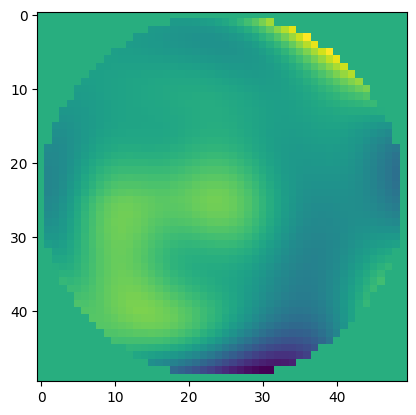

In [8]:
plt.imshow((frame - frame.min())/(frame.max() - frame.min()))

In [ ]:
plot_diagrams(mini_square)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

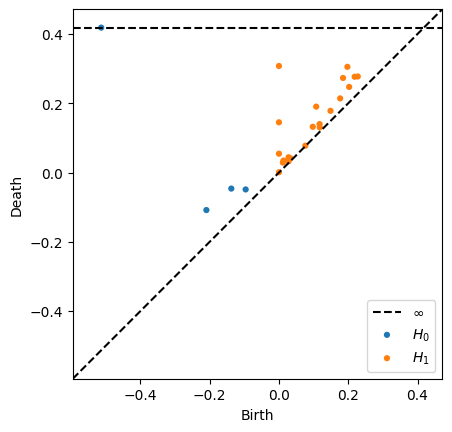

In [14]:
pd = [np.array(mini_square[0]), np.array(mini_square[1])]
plot_diagrams(pd)

In [15]:
imgs = []
pds = []

In [30]:
for t in range(98):
    img = interp_maps[t, :, :]
    mini_sphere = cubical_pd_from_image(img)
    cc_sphere.append(mini_sphere)

    interpolator = RegularGridInterpolator((phi, theta), interp_maps[t], bounds_error=False, fill_value=0)
    pts = np.stack([phi_map[mask], theta_map[mask]], axis=-1)
    vals = interpolator(pts)
    frame = np.zeros((N, N))
    frame[mask] = vals
    mini_square = cubical_pd_from_image(frame)
    imgs.append(frame)

    cc_square.append(mini_square)
    pds.append([np.array(mini_square[0]), np.array(mini_square[1])])
    fig = plt.figure()
    plt.imshow(frame)
    plt.savefig("imgs" + str(t) + ".png")
    plt.close()

In [27]:
np.array(imgs).shape

(1176, 50, 50)

In [ ]:
for t in range(98):
    fig = plt.figure()
    plt.imshow(imgs(t))
    plt.figsave

In [28]:
import imageio
import numpy as np

# frames: numpy array of shape (N, H, W) or (N, H, W, 3)
# Example: frames = your_3d_matrix

imageio.mimsave("animation.gif", np.array(imgs), fps=10)

In [19]:
imageio.mimsave("animation.gif", pds, fps=10)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

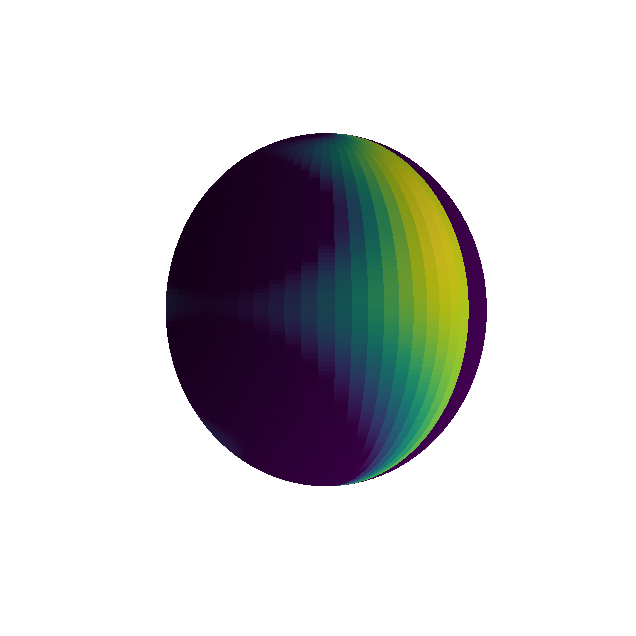

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Your data: M is 128x64
# M = ...

M = img  # example dummy data

# Dimensions
n_lat, n_lon = M.shape   

# Longitude: 0 → 2π
phi = np.linspace(0, 2*np.pi, n_lon)

# Latitude: 0 → π
theta = np.linspace(0, np.pi, n_lat)

phi_grid, theta_grid = np.meshgrid(phi, theta)

# Sphere coordinates
x = np.sin(theta_grid) * np.cos(phi_grid)
y = np.sin(theta_grid) * np.sin(phi_grid)
z = np.cos(theta_grid)

# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(
    x, y, z,
    facecolors=plt.cm.viridis(M / M.max()),
    rstride=1, cstride=1,
    linewidth=0, antialiased=False
)

ax.set_box_aspect([1,1,1])  # Equal aspect ratio
ax.axis('off')
ax.view_init(elev=0)

plt.show()
